# **Trabajo final - Proyecto 4**

Nombre y Apellido: Rogelio Pettenon

Github: 

La elaboración de este trabajo toma como referencia la documentación indicada debajo

https://torres.ai/redes-neuronales-recurrentes/

https://www.tensorflow.org/text/tutorials/text_classification_rnn



## **Recurrent Neural Networks**

El objetivo de este trabajo es profundizar el Proyecto 3 implementando modelos de Deep Learning, para ello utilizaré Recurrent Neural Networks. Las RNN están capacitadas para reconocer patrones en datos secuenciales como, por ejemplo: los textos. Con la ayuda de las RNN espero poder reconocer aquellos patrones de palabras que subyacen en el texto.

¿Cómo funcionan las redes neuronales? Las redes neuronales están compuestas por capas, la primera capa, bien conocida como "input layer", es donde se insertan nuestros datos. Luego le siguen una serie de capas conocidas como "hidden layers" las cuales aplican tranasformaciones (lineales o no lineales) a los datos para luego llegar a la última capa, la "output layer", la cual nos muestra la clasificación que hizo la red.

Para comparar las metricas con los modelos implementados en el proyecot 3 tomare los resultados del analisis exploratorio y el procesamiento de texto anterior y hare la implementación correspondiente

In [1]:
# Librerias necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Librerias para obtener metricas
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [2]:
#path
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Acamica_Proyecto3/data_lemma_1.csv') 

In [3]:
data.tail()

,product_category,review_title,review_body,stars,review_body_length,review_title_length,review_body_lemma
209995,wireless,Perfectos para lo que sirven,Para lo que cuesta es perfecto porque cumple s...,5,NaN,NaN,para costar perfecto cumplir función sobra ade...
209996,wireless,"Buen vendedor, rápido y fiable.","Material muy flexible y cómodo, acorde a la de...",5,NaN,NaN,material flexible cómodo acorde descripción
209997,home,medallas con bonito grabado,Se ve bien el grabado,5,NaN,NaN,bien grabado
209998,sports,timbre,lo compré para mi bici pero finalmente se lo h...,5,NaN,NaN,comprar bici finalmente quedar xiaomi scooter ...
209999,electronics,Auriculares sin cables de verdad,Pues este tipo de cascos si que son inalambric...,5,NaN,NaN,pues tipo casco inalambrico no atado goma tipi...


In [4]:
#data = pd.read_csv('data_lemm.csv')
data['review_body_lemma'] = data['review_body_lemma'].astype(str)
# Elimino los registros con datos faltantees
data = data[data['review_body_lemma'] != "nan" ]

In [5]:
# Creo función para generar matriz de confusión
def plot_cm(y,y_pred):
    names=["1","2","3","4","5"]
    cm=confusion_matrix(y,y_pred)
    f,ax=plt.subplots(figsize=(7,7))
    sns.heatmap(cm,annot=True,ax=ax,fmt=".0f", cmap="YlGnBu")
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

## Text classification with a RNN
Para armar mi modelo utilizaré la librería TensorFlow junto a Keras. Comenzaré definiendo la variable independiente y la dependiente, luego realizo separación de los datos para entrenamiento y testeo

In [6]:
x = np.array(data['review_body_lemma'])
y = np.array(data['stars'])

# Separo un 80% para entrenar y dejo el 20% que luego separo en 50% para test y 50 % para dev
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)
xtest, xdev, ytest, ydev = train_test_split(xtest,ytest,test_size=0.5,random_state=42,stratify=ytest)

Dado que las entradas en una red neuronal deben ser tensores de datos numéricos primero debo realizar la conversión denominada “vectorización” de datos, en este caso utilizo One-hot Encoding

In [7]:
import tensorflow as tf
from keras.callbacks import EarlyStopping # nos permite detener el entrenamiento cuando una métrica monitoreada haya dejado de mejorar
import random

Como la funcion to_categorical espera recibir valores integer entre 0-(# clases) le dire que hay 6 clases y luego removere la que es considerada como la clase 0

In [8]:
ytrain_cat = tf.keras.utils.to_categorical(ytrain, num_classes=6)
ytest_cat = tf.keras.utils.to_categorical(ytest, num_classes=6)
ydev_cat = tf.keras.utils.to_categorical(ydev, num_classes=6)

In [9]:
ytrain_cat

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [10]:
# Elimino la categoría 0
ytrain_cat = np.delete(ytrain_cat,0,axis=1)
ytest_cat = np.delete(ytest_cat,0,axis=1)
ydev_cat = np.delete(ydev_cat,0,axis=1)

Veamos algunos ejemplos de como es el one hot encoding:

In [11]:
indexes = random.sample(range(0, len(ytrain)), 12)

for i in indexes:
    print("Clase: ",ytrain[i], "-> One hot encoding -> ", ytrain_cat[i])

Clase:  5 -> One hot encoding ->  [0. 0. 0. 0. 1.]
Clase:  5 -> One hot encoding ->  [0. 0. 0. 0. 1.]
Clase:  1 -> One hot encoding ->  [1. 0. 0. 0. 0.]
Clase:  1 -> One hot encoding ->  [1. 0. 0. 0. 0.]
Clase:  1 -> One hot encoding ->  [1. 0. 0. 0. 0.]
Clase:  5 -> One hot encoding ->  [0. 0. 0. 0. 1.]
Clase:  1 -> One hot encoding ->  [1. 0. 0. 0. 0.]
Clase:  4 -> One hot encoding ->  [0. 0. 0. 1. 0.]
Clase:  1 -> One hot encoding ->  [1. 0. 0. 0. 0.]
Clase:  4 -> One hot encoding ->  [0. 0. 0. 1. 0.]
Clase:  4 -> One hot encoding ->  [0. 0. 0. 1. 0.]
Clase:  3 -> One hot encoding ->  [0. 0. 1. 0. 0.]


Crearé mis datasets en formato Tensorflow:

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((xtrain, ytrain_cat))
test_dataset = tf.data.Dataset.from_tensor_slices((xtest, ytest_cat))
dev_dataset = tf.data.Dataset.from_tensor_slices((xdev, ydev_cat))

In [13]:
train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float32)>

Los modelos en tensorflow se entrenan por varias pasadas por el conjunto de entrenamiento completo (epochs) y en cada pasada se entrena sobre una porción del dataset a la vez (batches), voy a definir el tamaño de cada una de estas porciones o batches:

In [14]:
BUFFER_SIZE = len(train_dataset)
BATCH_SIZE = 64

In [15]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
dev_dataset = dev_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Ejemplo:

In [16]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])

texts:  [b'despu\xc3\xa9s mes no fiable costar detectar entender precio no poder pedir mucho'
 b'mal\xc3\xadsimos pillar amigo comprar llevar parecer buen cabo mes comprar marca obviamente comenzar fallar cable micr\xc3\xb3fono no caro no esperar calidad 100% esperar romper r\xc3\xa1pido resumir p\xc3\xa9rdida dinero'
 b'siempre apagar cambiar disco']

labels:  [[0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]



## Creando el encoder de texto:
El texto crudo necesita ser procesado antes de ser utilizado por el modelo. Utilizaré el método más sencillo propuesto en el tutorial para procesar mi texto para entrenamiento utilizando tf.keras.layers.experimental.processing.TextVectorization. Crearé la capa y le pasaré el texto del dataset al método .adapt

In [17]:

VOCAB_SIZE = 1000 #La cantidad de palabras con la que aprendera mi encoder.
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

El método .adapt fija el vocabulario de la capa. Veamos los primeros 20 tokens generados, los primeros dos serán el padding y aquellos tokens desconocidos:

In [18]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'no', 'bien', 'él', 'calidad', 'producto', 'buen',
       'precio', 'poco', 'mucho', 'comprar', 'llegar', 'funcionar',
       'venir', 'quedar', 'tener', 'gustar', 'pequeño', 'perfecto'],
      dtype='<U14')

Una vez que la capa está definida esta puede encodear texto a una matríz de integers:

In [19]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[256,  59,   2, 863,  92, 663, 258,   8,   2,  33,  36,  10,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   1, 909,  11,  52,  72,   7, 658,  59,  11,  73,   1, 998,
        305,  71, 867,   2, 120,   2,  21,   5, 259,  21,  46,  40,   1,
          1,  88,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1, 286,  98, 428,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
      

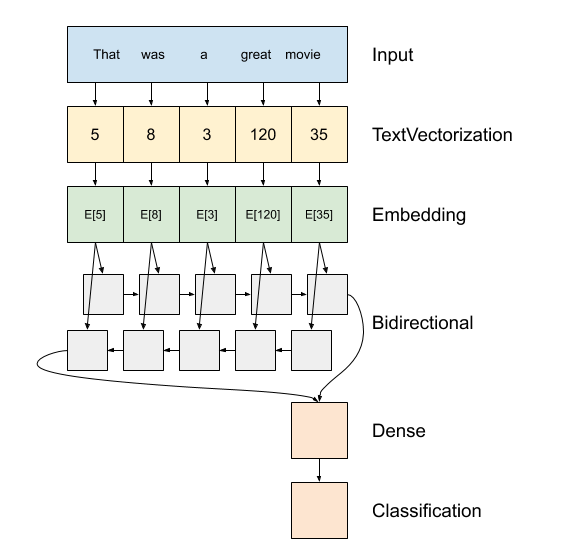


Arriba se encuentra el diagrama del modelo:

La primer capa es un encoder que convierte el texto a una secuencia de tokens.

Luego del encoder hay una capa de embedding. La capa de embedding almacena un vector por palabra. Al ser llamada, convierte las secuencias de indices de palabras a secuencias de vectores. Estos vectores son sobre los que se entrenará. Luego del entrenamiento (sobre una cantidad de datos suficiente), palabras con significados similares usualmente tendrán vectores similares.

Una Red Neuronal Recurrente (RNN) procesa la entrada de secuencia al iterar por cada uno de sus elementos. Las RNN pasan los outputs de un elemento al input del siguiente, aprovechando la secuencialidad de los datos. La capa tf.keras.layers.Bidirectional propaga la entrada hacia adelante y hacia atrás a través de la capa RNN y luego concatena la salida final.

La principal ventaja de un RNN bidireccional es que la señal desde el principio de la entrada no necesita procesarse hasta el final en cada paso de tiempo para afectar la salida.

La principal desventaja de un RNN bidireccional es que no puede transmitir predicciones de manera eficiente a medida que se agregan palabras al final.

Una vez que la RNN ha convertido la secuencia en un solo vector, las layers.Dense realizan un procesamiento final, aplicando transformaciones no lineales a los vectores resultantes y obteniendo al final un vector con 5 elementos, donde cada uno es la probabilidad de perteneces a la i-ésima clase.

Imagen y texto extraido del tutorial de Tensorflow

Se modificó la red expuesta en la imagen para que tenga otra capa bidireccional y dos capas layers.Dense, además la última capa a diferencia de las otras layers.Dense tendrá como función activadora la función softmax la cual es utilizada para clasificación de multiples clases.

In [42]:

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),

    tf.keras.layers.Dense(5, activation='softmax')
])

La capa embedding utiliza enmascaramiento para manejar las diferentes longitudes de secuencia. Todas las capas siguientes a esta soportan este enmascaramiento.
La capa Dense junto con la activacion "relu", permiten que la red neuronal pueda aumentar su performance, acelerar el aprendizaje y evitar la desaparicion del gradiente (porque la activacion relu reemplaza los pesos negativos por cero)

In [43]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True, True, True, True, True]


Para confirmar que esta red funciona como se esperaba, evalúo una oración dos veces. Primero, solo para que no haya relleno para enmascarar:

In [44]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.20001261 0.19962494 0.1991152  0.20101164 0.20023564]


Ahora lo evalúo nuevamente en un lote con una oración más larga. El resultado debería ser idéntico:

In [45]:
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.20001261 0.19962494 0.1991152  0.20101164 0.20023562]


Compilaré el modelo utilizando como función de perdida la categorical_crossentropy y como mi optimizador a Adam para configurar e proceso de entrenamiento

In [46]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

Veamos como se ve la red neuronal:

In [47]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 32)               


Voy a entrenar mi modelo utilizando EarlyStopping que hará que al finalizar cada epoch, si mi modelo no disminuyó su loss en dev, finalice el entrenamiento:

In [48]:
checkpoint = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=10, verbose=1, mode="max", baseline=None, restore_best_weights=False)

callbacks_list = [checkpoint]

history = model.fit(train_dataset, epochs=5,
                    validation_data=dev_dataset,
                    callbacks=callbacks_list,
                    verbose=1)

Epoch 1/5
2625/2625 [==============================] - 656s 244ms/step - loss: 1.2092 - accuracy: 0.4590 - val_loss: 1.1553 - val_accuracy: 0.4846
Epoch 2/5
2625/2625 [==============================] - 647s 246ms/step - loss: 1.1392 - accuracy: 0.4938 - val_loss: 1.1269 - val_accuracy: 0.4961
Epoch 3/5
2625/2625 [==============================] - 641s 244ms/step - loss: 1.1155 - accuracy: 0.5031 - val_loss: 1.1223 - val_accuracy: 0.5040
Epoch 4/5
2625/2625 [==============================] - 639s 243ms/step - loss: 1.1012 - accuracy: 0.5083 - val_loss: 1.1206 - val_accuracy: 0.5010
Epoch 5/5
2625/2625 [==============================] - 671s 256ms/step - loss: 1.0878 - accuracy: 0.5162 - val_loss: 1.1223 - val_accuracy: 0.5062


Veamos las métricas sobre test:

In [49]:
test_dataset = tf.data.Dataset.from_tensor_slices((xtest, ytest_cat))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [50]:

ytest_pred = model.predict(test_dataset)

# Transformo las predicciones a las clases originales (1,2,3,4,5)
Ytest_pred = []
for y in ytest_pred:
    clase = np.argmax(y)+1
    Ytest_pred.append(clase)
ytest_pred = Ytest_pred
ytest_pred = np.array(ytest_pred)

In [51]:
acc_test = accuracy_score(ytest, ytest_pred)

print("Accuracy en test: " + str(acc_test))

Accuracy en test: 0.5014049626137067


Veamos la matriz de confusión:

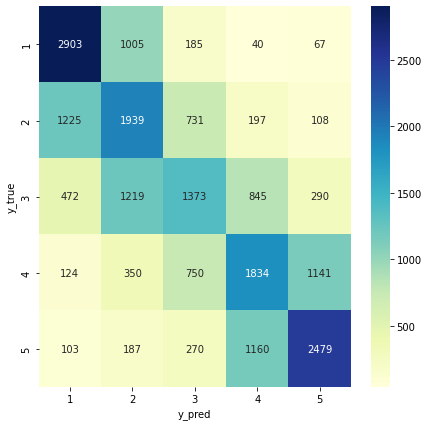

In [52]:
plot_cm(ytest,ytest_pred)

Veamos el reporte del clasificador:

In [53]:
print(classification_report(ytest,ytest_pred))

              precision    recall  f1-score   support

           1       0.60      0.69      0.64      4200
           2       0.41      0.46      0.44      4200
           3       0.41      0.33      0.37      4199
           4       0.45      0.44      0.44      4199
           5       0.61      0.59      0.60      4199

    accuracy                           0.50     20997
   macro avg       0.50      0.50      0.50     20997
weighted avg       0.50      0.50      0.50     20997



Veamos como fue evolucionando el accuracy y el loss a lo largo del entrenamiento:

In [54]:
history_dict = history.history

In [55]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

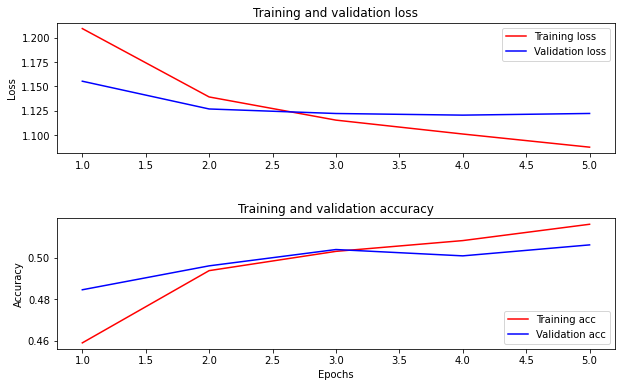

In [56]:
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

Como era de esperar se observa una gran mejora en el desempeño de este modelo, incluso se podría haber entrenado por más epochs y quizás obtener un mejor desempeño.

## Conclusión:
El campo de redes neuronales es muy amplio y aqui se expone un primer modelo donde se visualiza una notoria mejora.


Como punto a trabajar se podria analizar frecuencia de palabras similares entre clases ya que estas producen vectores similares y al quitarlas podria mejorar el modelo.


Como primer trabajo en este campo de redes neuronales me desafía a seguir profundizando para nuevos modelos y aplicaciones. Un campo de estudio que me despierta mucho interes son los chatbot y estudiaré modelos con redes nueronales